In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python import keras as kt
# RNN imports
import keras
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, RNN, SimpleRNN, GRU
from keras.utils import to_categorical


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Using TensorFlow backend.


Training/Valid data shape: (2115, 25, 1000)
Test data shape: (443, 25, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [6]:
# Separate data by subject

# samples from subject 0
idx_p0_train = np.where(person_train_valid == 0)[0]
idx_p0_test = np.where(person_test == 0)[0]

p0_train_X = X_train_valid[idx_p0_train] 
p0_train_y = y_train_valid[idx_p0_train]

p0_test_X = X_test[idx_p0_test]
p0_test_y = y_test[idx_p0_test]

print(p0_train_X.shape)
print(p0_train_y.shape)
print(p0_test_X.shape)
print(p0_test_y.shape)



(237, 25, 1000)
(237,)
(50, 25, 1000)
(50,)
Swapped axes: (237, 1000, 25) (50, 1000, 25)
Removed VOG channels: (237, 1000, 22) (50, 1000, 22)
Raw labels: [771 772 769 769 769 769 771 770 772 772]
Fixed: [2 3 0 0 0 0 2 1 3 3]
Categorical one-hot encoding:
 [[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


In [ ]:
################################
# Sliding window subsampling

# data size (1000, 22)
# data 

In [ ]:
################################
# rearrange data for Keras modules

# fomat data to (batch_size, timesteps, input_dim)
k_X_train = np.swapaxes(p0_train_X, 1, 2)
k_X_test = np.swapaxes(p0_test_X, 1, 2)
print("Swapped axes:",k_X_train.shape, k_X_test.shape)
# remove VOG channels (23-25)
k_X_train = k_X_train[: , : , :22 ]
k_X_test = k_X_test[: , : , :22 ]
print("Removed VOG channels:", k_X_train.shape, k_X_test.shape)

# encode output labels
print("Raw labels:", p0_train_y[0:10])
k_y_train = p0_train_y - 769
k_y_test = p0_test_y - 769
print("Fixed:", k_y_train[0:10])
k_y_train_categ = to_categorical(k_y_train, 4)
k_y_test_categ = to_categorical(k_y_test, 4)
print("Categorical one-hot encoding:\n",k_y_train_categ[0:3])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 991, 22)           4862      
_________________________________________________________________
batch_normalization_3 (Batch (None, 991, 22)           88        
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               57984     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 63,450
Trainable params: 63,406
Non-trainable params: 44
_________________________________________________________________
None
Train on 189 samples, validate on 48 samples
Epoch 1/25
189/189 [==============================] - 5s 25ms/step - loss: 1.4546 - acc: 0.2328 - val_loss: 1.4450 - val_acc: 0.2708
Epoch 2/25
189/189 [==============================] - 3s 18ms/step - loss: 1.3722 - ac

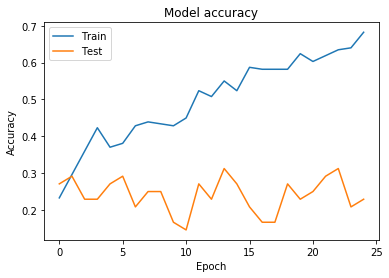

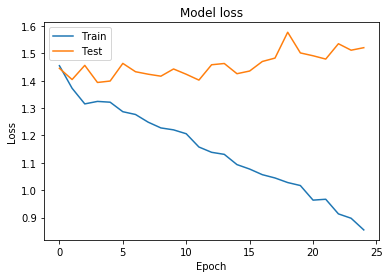

In [8]:
#################### RNN paramters
hids = 100
actv = 'tanh'
dcy = 0.005
reg = 0.1
lrt = 0.00005


#################### RNN training
input_dim = k_X_train.shape[1:]
gru_units_sub = 128

model = Sequential()
#model.add(keras.layers.Conv1D(22, 10, ))
#model.add(keras.layers.BatchNormalization())
model.add(GRU(gru_units_sub, recurrent_dropout=.4, input_shape=input_dim))
model.add(Dense(4, activation="softmax"))
model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

print(model.summary())

history = model.fit(k_X_train, k_y_train_categ, epochs=25, verbose=1, validation_split=0.2, batch_size=32)



#################### RNN loss and accuracy plotting
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()